In [ ]:
from radiant_mlhub import Dataset

ds = Dataset.fetch('c2smsfloods_v1')
for c in ds.collections:
    print(c.download(output_dir="cloud2street"))

In [ ]:
!pip install rasterio shapely geopandas scikit-image

In [2]:
import rasterio

# GeoTIFFファイルを開く
with rasterio.open('cloud2street/c2smsfloods_v1_source_s1/c2smsfloods_v1_source_s1_0/VH.tif') as src:
    # 画像データを読み込む
    data = src.read()

    # 画像のメタデータを取得する
    metadata = src.meta

(array([1.0000e+01, 1.2600e+02, 1.1610e+03, 7.8630e+03, 3.4382e+04,
        8.2927e+04, 8.9195e+04, 3.8815e+04, 7.0950e+03, 5.7000e+02]),
 array([-37.05379868, -33.3324852 , -29.61117363, -25.88986206,
        -22.16854858, -18.44723701, -14.72592354, -11.00461102,
         -7.28329897,  -3.56198621,   0.15932623]),
 <BarContainer object of 10 artists>)

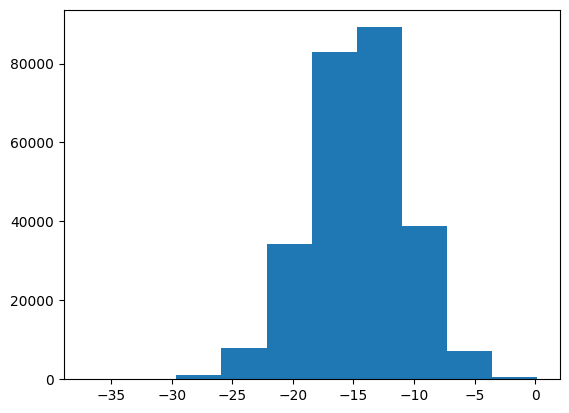

In [3]:
plt.hist(data.ravel())

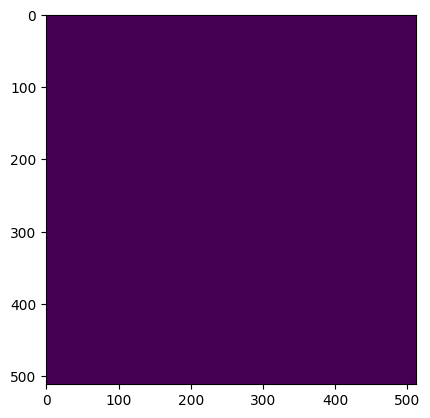

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(data[0] == 0)

In [81]:
import os
import rasterio
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose

class GeoTIFFDataset(Dataset):
    def __init__(self, root_dir, transforms=[], monopolar=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "c2smsfloods_v1_source_s1")
        self.label_folder = os.path.join(root_dir, "c2smsfloods_v1_labels_s1_water")
        self.image_files = sorted([f for f in os.listdir(self.image_folder) if os.path.isdir(os.path.join(self.image_folder, f))])
        self.label_files = sorted([f for f in os.listdir(self.label_folder) if f != "_common" and os.path.isdir(os.path.join(self.label_folder, f))])
        self.monopolar = monopolar
        self.transforms = Compose(transforms)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_vh_path = os.path.join(self.image_folder, self.image_files[idx], "VH.tif")
        image_vv_path = os.path.join(self.image_folder, self.image_files[idx], "VV.tif")
        label_path = os.path.join(self.label_folder, self.label_files[idx], "labels.tif")

        with rasterio.open(image_vh_path) as src:
            image_vh = src.read()
        with rasterio.open(image_vv_path) as src:
            image_vv = src.read()


        with rasterio.open(label_path) as src:
            label = src.read()

        image_vh_tensor = torch.from_numpy(image_vh).float()
        image_vv_tensor = torch.from_numpy(image_vv).float()
        image_tensor = torch.cat([image_vh_tensor, image_vv_tensor], dim=0)

        label_tensor = torch.from_numpy(label).long()
        
        # 画像に変換を適用
        if self.monopolar is None:
            mask = torch.all(image_tensor != 0, dim=0).long()
            image_tensor = self.transforms(image_tensor)
        elif self.monopolar.lower() == "vv":
            image_tensor = self.transforms(image_vv_tensor)
            mask = (image_vv_tensor!=0).long()[0]
        elif self.monopolar.lower() == "vh":
            image_tensor = self.transforms(image_vh_tensor)
            mask = (image_vh_tensor!=0).long()[0]
        # label_image = self.transforms(label_tensor)
        

        return image_tensor, label_tensor, mask

# データセットを作成
root_dir = "cloud2street"
dataset = GeoTIFFDataset(root_dir, monopolar="vv")

# データセットからサンプルを取得
image, label, mask = dataset[0]
print(image.shape, label.shape, mask.shape)

torch.Size([1, 512, 512]) torch.Size([1, 512, 512]) torch.Size([512, 512])


In [82]:
print(len(dataset.image_files))
print(len(dataset.label_files))

900
900


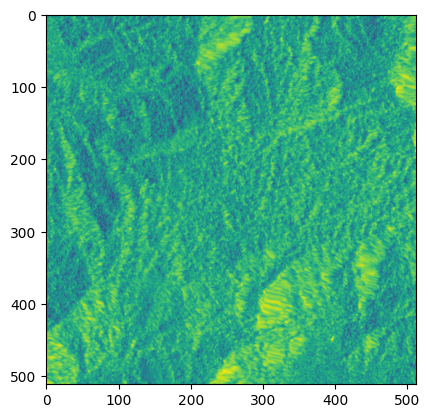

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(image[0])

In [83]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=128)

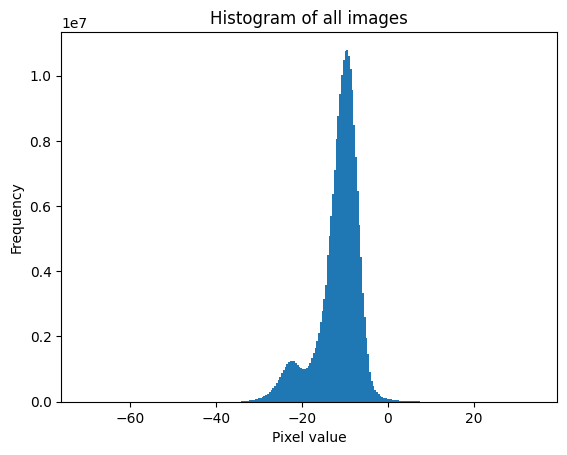

In [85]:
import numpy as np
from torch.utils.data import DataLoader

def rebin_histogram(hist, old_edges, new_edges):
    new_hist = np.zeros(len(new_edges) - 1)
    for i in range(len(hist)):
        left = np.searchsorted(new_edges, old_edges[i], side="left")
        right = np.searchsorted(new_edges, old_edges[i+1], side="right")
        new_hist[left:right] += hist[i]
    return new_hist

def compute_histogram_dynamic(loader, num_bins=256):
    min_value, max_value = float("inf"), float("-inf")
    hist = np.zeros(num_bins)
    bin_edges = None
    
    for images, labels, mask in loader:
        expanded_mask = mask.unsqueeze(1).repeat(1, images.shape[1], 1, 1)
        expanded_mask = expanded_mask.numpy().ravel()
        images_np = images.numpy().ravel()
        images_np = images_np[expanded_mask!=0]
        batch_min, batch_max = images_np.min(), images_np.max()
        
        if batch_min < min_value or batch_max > max_value:
            new_min_value = min(min_value, batch_min)
            new_max_value = max(max_value, batch_max)
            new_bin_edges = np.linspace(new_min_value, new_max_value, num_bins + 1)
            
            if bin_edges is not None:
                hist = rebin_histogram(hist, bin_edges, new_bin_edges)
            
            bin_edges = new_bin_edges
            min_value, max_value = new_min_value, new_max_value
        
        batch_hist, _ = np.histogram(images_np, bins=bin_edges)
        hist += batch_hist

    return hist, bin_edges

loader = DataLoader(dataset, batch_size=256)
hist, bin_edges = compute_histogram_dynamic(loader)

# ヒストグラムを表示
import matplotlib.pyplot as plt

plt.bar(bin_edges[:-1], hist, width=bin_edges[1] - bin_edges[0])
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.title("Histogram of all images")
plt.show()


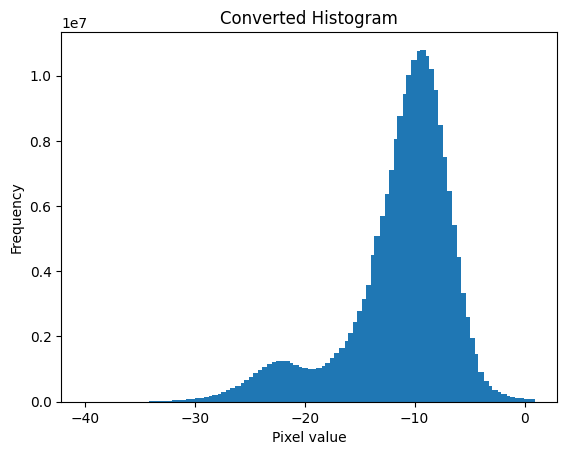

In [86]:
def convert_histogram(hist, old_edges, new_min_value, new_max_value, num_bins):
    new_bin_edges = np.linspace(new_min_value, new_max_value, num_bins + 1)
    new_hist = rebin_histogram(hist, old_edges, new_bin_edges)
    return new_hist, new_bin_edges

old_hist = hist
old_bin_edges = bin_edges
new_min_value = -40
new_max_value = 1
num_bins = 256

new_hist, new_bin_edges = convert_histogram(old_hist, old_bin_edges, new_min_value, new_max_value, num_bins)

# 新しいヒストグラムを表示
plt.bar(new_bin_edges[:-1], new_hist, width=new_bin_edges[1] - new_bin_edges[0])
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.title("Converted Histogram")
plt.show()


In [87]:
def find_median(hist, bin_edges):
    cdf = np.cumsum(hist) / np.sum(hist)  # 累積分布関数 (CDF) を計算
    median_bin_idx = np.argmin(np.abs(cdf - 0.5))  # CDFが0.5に最も近いビンのインデックスを取得
    median = bin_edges[median_bin_idx]  # 対応するビンエッジから中央値を取得
    return median

median = find_median(hist, bin_edges)
print("Median:", median)


Median: -10.707138121128082


In [88]:
import torch
from torchvision.transforms import Lambda

def custom_normalize(image, median, std_dev):
    # NumPy配列をPyTorchテンソルに変換
    # image = torch.tensor(image, dtype=torch.float32)

    # 中央値を減算して中央値が0になるようにする
    image = image - median

    # 標準偏差で除算してほとんどのピクセル値が範囲(-1, 1)に収まるようにスケーリングする
    image = image / std_dev

    return image

def argument_channels(image):
    image = torch.concat([image, image, image], dim=0)
    return image


# 分散を計算して標準偏差を求める
variance = np.average((bin_edges[:-1] - median) ** 2, weights=hist)
std_dev = np.sqrt(variance)
print("std_dev:", std_dev)
# median = -17.233137786388397
# std_dev = 5.842539646934703

# カスタム変換を作成
normalize_transform = Lambda(lambda image: custom_normalize(image, median, 3 * std_dev))
argument_channel_transform = Lambda(lambda image: argument_channels(image))

std_dev: 5.014976117062999


In [89]:
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomVerticalFlip

enable_augmentation = True
if enable_augmentation == True:
    transforms_list = [
        normalize_transform,
    ]
else:
    transforms_list = [
        normalize_transform,
    ]

# データセットを作成
root_dir = "cloud2street"
dataset = GeoTIFFDataset(root_dir, transforms=transforms_list, monopolar='vv')

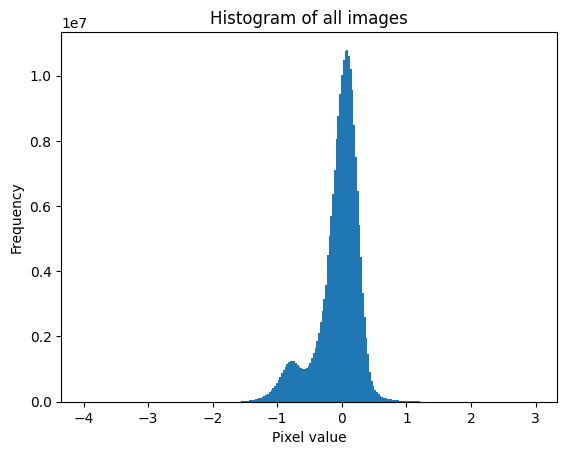

In [90]:
loader = DataLoader(dataset, batch_size=256)
hist, bin_edges = compute_histogram_dynamic(loader)

# ヒストグラムを表示
import matplotlib.pyplot as plt

plt.bar(bin_edges[:-1], hist, width=bin_edges[1] - bin_edges[0])
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.title("Histogram of all images")
plt.show()

In [91]:
from torch.utils.data import random_split

# データセットを訓練用とテスト用に分割
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

print(f"Train set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")



Train set size: 720
Test set size: 180


In [92]:
from torch.utils.data import DataLoader
trainloader = DataLoader(train_set, batch_size=4)
testloader = DataLoader(test_set, batch_size=4)

In [93]:
!nvidia-smi

Wed Oct  4 19:13:18 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090      WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   35C    P8               8W / 350W |  16671MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [95]:
from torch import nn

unet = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)
# 入力層だけ変える．

monopolar = "vv"
if monopolar == "vv":
    net = nn.Sequential(
      nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, bias=False),
      unet
    )
else:
    net = nn.Sequential(
      nn.Conv2d(2, 3, kernel_size=3, stride=1, padding=1, bias=False),
      unet
    )
net = net.to('cuda')

Using cache found in C:\Users\MIRAI2023_HPC_04/.cache\torch\hub\milesial_Pytorch-UNet_master


In [96]:
import torch
from torchvision import transforms
from PIL import Image
import random

class JointRandomHorizontalFlip(transforms.RandomHorizontalFlip):
    def __call__(self, img):
        if random.random() < self.p:
            self.flip = True
            return transforms.functional.hflip(img)
        self.flip = False
        return img

    def mask_call(self, mask):
        if self.flip:
            return transforms.functional.hflip(mask)
        return mask

class JointRandomVerticalFlip(transforms.RandomVerticalFlip):
    def __call__(self, img):
        if random.random() < self.p:
            self.flip = True
            return transforms.functional.vflip(img)
        self.flip = False
        return img

    def mask_call(self, mask):
        if self.flip:
            return transforms.functional.vflip(mask)
        return mask

class JointHVFlip:
    def __init__(self):
        self.HFlip = JointRandomHorizontalFlip()
        self.VFlip = JointRandomVerticalFlip()

    def __call__(self, image, mask):
        image = self.HFlip(image)
        mask = self.HFlip.mask_call(mask)
        image = self.VFlip(image)
        mask = self.VFlip.mask_call(mask)
        return image, mask
    
# JointTransformを使って画像とマスクに同じ変換を適用
joint_transform = JointHVFlip()
transformed_image, transformed_mask = joint_transform(image, mask)

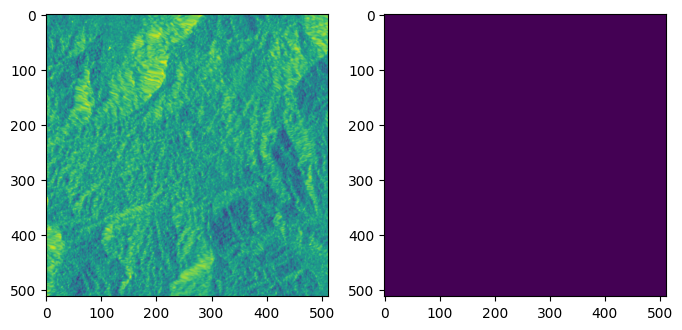

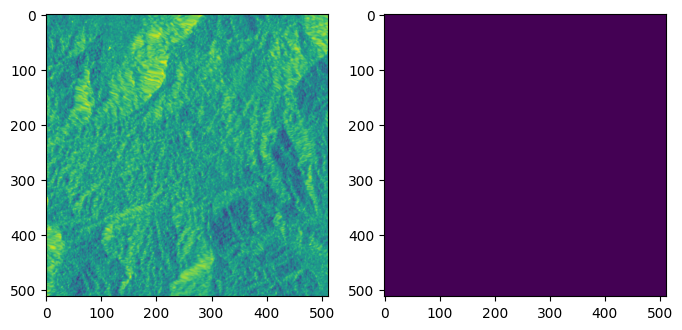

In [97]:

transformed_image, transformed_mask = joint_transform(image, mask)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(transformed_image[0].numpy())
plt.subplot(122)
plt.imshow(transformed_mask.numpy())

transformed_image, transformed_mask = joint_transform(image, mask)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(transformed_image[0].numpy())
plt.subplot(122)
plt.imshow(transformed_mask.numpy())

In [98]:
import torch
import torch.nn.functional as F

def masked_cross_entropy_loss(outputs, targets, mask):
    """
    outputs: モデルの出力 [batch_size, num_classes, ...] 
    targets: 正解のラベル [batch_size, ...]
    mask: マスクデータ [batch_size, ...], 通常は0または1の値を持つテンソル
    """
    # CrossEntropyLossを要素ごとに計算 (reduction='none'でバッチ内の平均を取らない)
    ce_loss = F.cross_entropy(outputs, targets, reduction='none')
    
    # マスクを適用
    masked_loss = ce_loss * mask
    
    # マスクを適用した損失の平均を計算して返す
    return masked_loss.sum() / mask.sum()

In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time
import os

# 損失関数とオプティマイザの定義
#criterion = nn.CrossEntropyLoss()
criterion = masked_cross_entropy_loss
optimizer = optim.Adam(net.parameters())

# 学習エポック数
num_epochs = 1000

# TensorBoardのSummaryWriterの作成
writer = SummaryWriter()

# モデルの重みを保存するディレクトリ
model_save_dir = "saved_models/20231004"
os.makedirs(model_save_dir, exist_ok=True)

start_time = time.time()

# 学習ループ
min_test_loss = 1.
for epoch in range(num_epochs):
    running_loss = 0.0
    epoch_start_time = time.time()

    for i, (inputs, labels, mask) in enumerate(trainloader):
        # GPUが利用可能な場合、データをGPUに転送
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
            mask = mask.cuda()

        # 勾配をゼロに初期化
        optimizer.zero_grad()

        inputs, mask = joint_transform(inputs, mask)
        
        # 順伝播
        outputs = net(inputs)
        # 損失の計算
        loss = criterion(outputs, labels.squeeze(1).long(), mask)
        # 逆伝播
        loss.backward()
        # 重みの更新
        optimizer.step()

        running_loss += loss.item()

    # エポックごとの統計情報の表示
    avg_loss = running_loss / len(trainloader)
    print(f"[Epoch {epoch + 1}] Loss: {avg_loss:.3f}")
    writer.add_scalar("training loss", avg_loss, epoch)

    # Testloaderに対する損失の計算
    test_running_loss = 0.0
    with torch.no_grad():
        for i, (inputs, labels, mask) in enumerate(testloader):
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
                mask = mask.cuda()

            outputs = net(inputs)
            loss = criterion(outputs, labels.squeeze(1).long(), mask)
            test_running_loss += loss.item()

        avg_test_loss = test_running_loss / len(testloader)
        print(f"[Epoch {epoch + 1}] Test Loss: {avg_test_loss:.3f}")
        writer.add_scalar("test loss", avg_test_loss, epoch)
        
        if avg_test_loss < min_test_loss:
            min_test_loss = avg_test_loss
            if (epoch+1) > 50:
                torch.save(net.state_dict(), os.path.join(model_save_dir, f"model_epoch_{epoch + 1}.pth"))                

    # 50エポックごとにモデルの重みを保存
    if (epoch + 1) % 50 == 0:
        torch.save(net.state_dict(), os.path.join(model_save_dir, f"model_epoch_{epoch + 1}.pth"))

    # 経過時間と1エポックあたりの所要時間の表示
    elapsed_time = time.time() - start_time
    epoch_elapsed_time = time.time() - epoch_start_time
    print(f"Elapsed Time: {elapsed_time:.2f}s, Epoch Time: {epoch_elapsed_time:.2f}s")

print("Finished Training")

# SummaryWriterの終了
writer.close()

[Epoch 1] Loss: 0.375
[Epoch 1] Test Loss: 0.326
Elapsed Time: 66.93s, Epoch Time: 66.93s
[Epoch 2] Loss: 0.347
[Epoch 2] Test Loss: 0.325
Elapsed Time: 133.65s, Epoch Time: 66.71s
[Epoch 3] Loss: 0.338
[Epoch 3] Test Loss: 0.317
Elapsed Time: 200.89s, Epoch Time: 67.24s
[Epoch 4] Loss: 0.346
[Epoch 4] Test Loss: 0.316
Elapsed Time: 268.12s, Epoch Time: 67.23s
[Epoch 5] Loss: 0.329
[Epoch 5] Test Loss: 0.298
Elapsed Time: 335.51s, Epoch Time: 67.39s
[Epoch 6] Loss: 0.321
[Epoch 6] Test Loss: 0.300
Elapsed Time: 402.91s, Epoch Time: 67.40s
[Epoch 7] Loss: 0.314
[Epoch 7] Test Loss: 0.299
Elapsed Time: 470.40s, Epoch Time: 67.49s
[Epoch 8] Loss: 0.317
[Epoch 8] Test Loss: 0.284
Elapsed Time: 538.10s, Epoch Time: 67.70s
[Epoch 9] Loss: 0.308
[Epoch 9] Test Loss: 0.285
Elapsed Time: 605.80s, Epoch Time: 67.70s
[Epoch 10] Loss: 0.303
[Epoch 10] Test Loss: 0.274
Elapsed Time: 673.60s, Epoch Time: 67.80s
[Epoch 11] Loss: 0.302
[Epoch 11] Test Loss: 0.269
Elapsed Time: 741.50s, Epoch Time: 67.

In [14]:
answer = test_set[1][1][0].numpy()

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(answer)

In [16]:
with torch.no_grad():
    output = net(test_set[1][0].to('cuda').unsqueeze(0)).detach().cpu()
output.shape

torch.Size([1, 2, 512, 512])

In [17]:
result = torch.argmax(torch.nn.functional.softmax(output, dim=1), dim=1).numpy()

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(torch.argmax(torch.nn.functional.softmax(output, dim=1), dim=1).numpy()[0])

In [144]:
import matplotlib.pyplot as plt

def visualize_results(dataset, indices=[0]):
    if isinstance(indices, int):
        indices = [indices]

    fig, axs = plt.subplots(len(indices), 4, figsize=(20, 5*len(indices)))

    # Make sure axs is always a 2-D array
    if len(indices) == 1:
        axs = np.expand_dims(axs, axis=0)
    
    for i, idx in enumerate(indices):
        input_image, label = dataset[idx]

        # VVチャンネルを表示
        axs[i][0].imshow(input_image[0].numpy(), cmap='gray')
        axs[i][0].set_title('VV')

        # VHチャンネルを表示
        axs[i][1].imshow(input_image[1].numpy(), cmap='gray')
        axs[i][1].set_title('VH')

        with torch.no_grad():
            prediction = net(input_image.to('cuda').unsqueeze(0)).cpu()
            prediction = torch.argmax(torch.nn.functional.softmax(prediction, dim=1), dim=1).numpy()[0]

        # Predictionを表示
        axs[i][2].imshow(prediction, cmap='gray')
        axs[i][2].set_title('Prediction')

        # Labelを表示
        axs[i][3].imshow(label[0].numpy(), cmap='gray')
        axs[i][3].set_title('Groundtruth')

    plt.show()

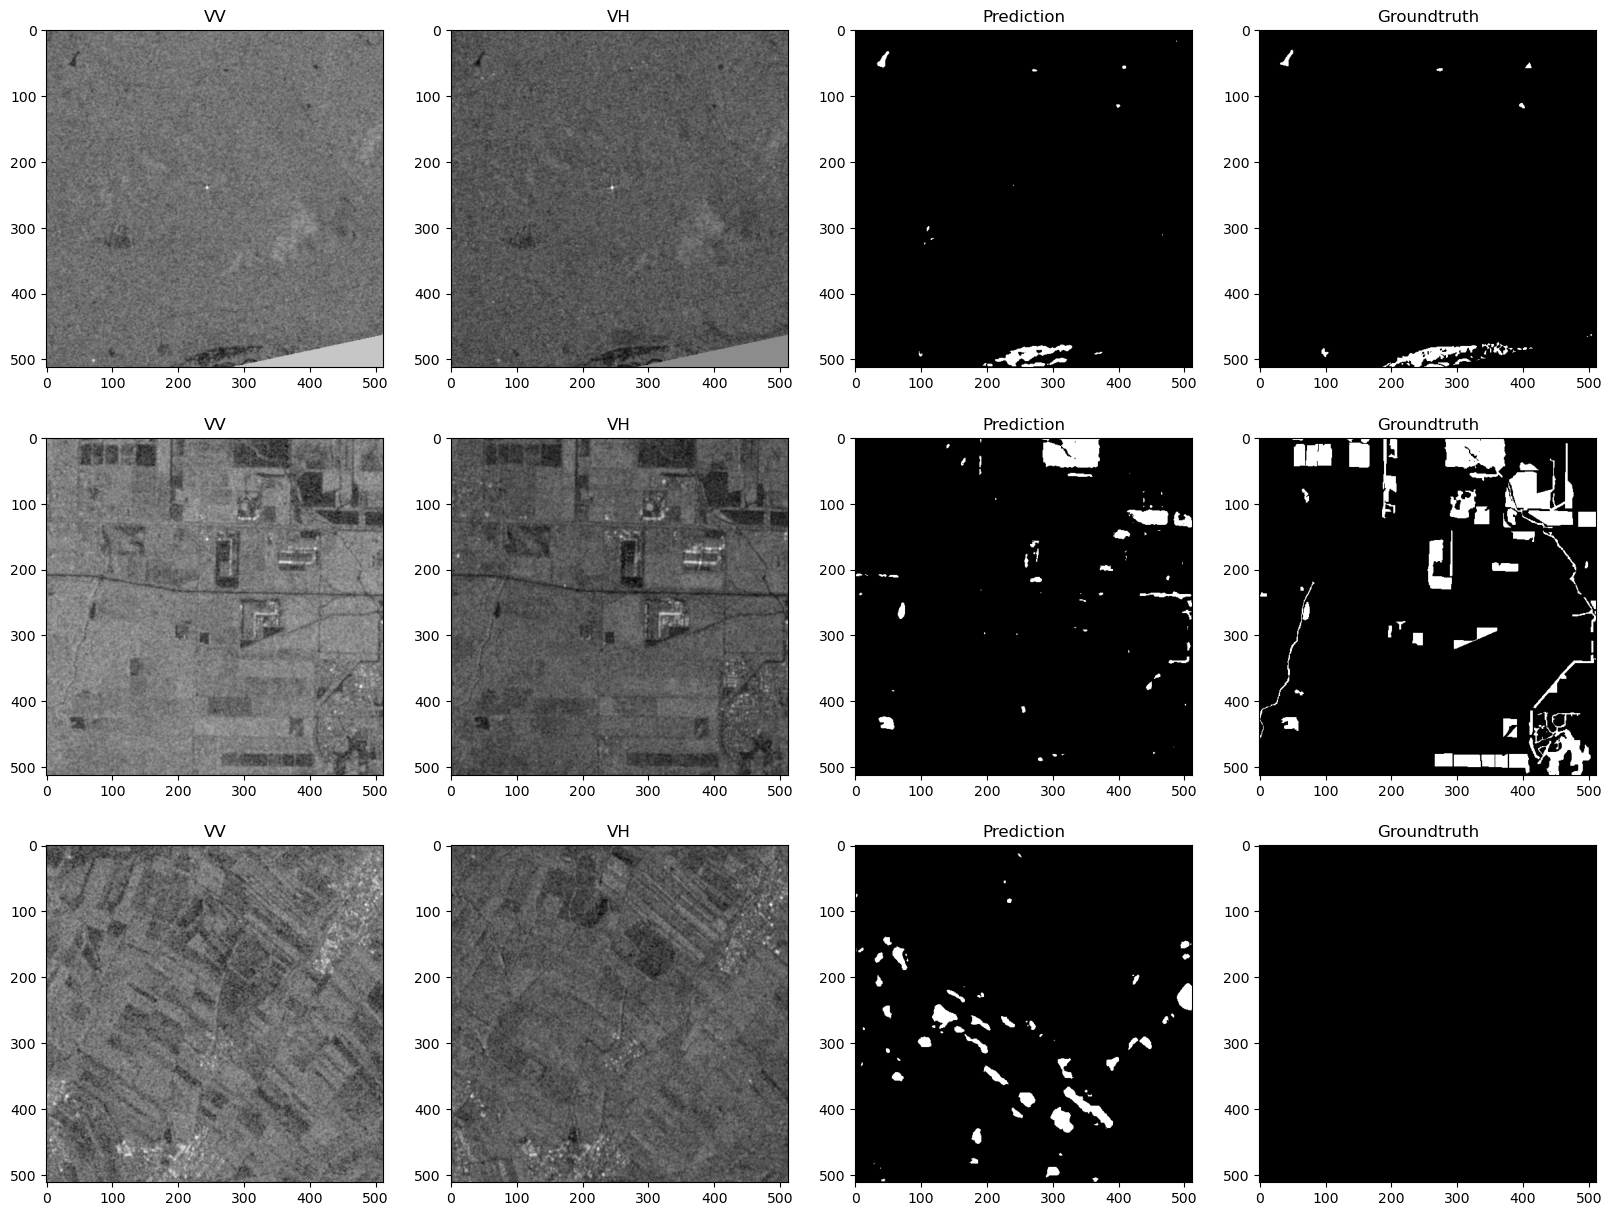

In [145]:
visualize_results(test_set, [0, 3, 4])